<h2 align = 'center' style="font-size: 48px;">Plant Disease Detection Through Computer Vision </h2>

## Importing Necessary Libraries & Dataset

In [55]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

#C-Vision + File Handling
import os
import glob as gb
import cv2

#Data Analytics
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', None)

#Evaluation Metrics
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay ,f1_score


#Neural Networking
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPool2D , Flatten
from tensorflow.keras.optimizers import Adam


In [56]:
# Import train, validation, test datasets


train_path = 'dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
validation_path = 'dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_path = 'dataset/test'


In [57]:
# Function To Walk Thru Datasets

def walk_through_data(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directions and {len(filenames)} images in {dirpath}")


In [58]:
#Walking through train dataset 
walk_through_data(train_path)

There are 38 directions and 0 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
There are 0 directions and 2016 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train\Apple___Apple_scab
There are 0 directions and 1987 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train\Apple___Black_rot
There are 0 directions and 1760 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train\Apple___Cedar_apple_rust
There are 0 directions and 2008 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train\Apple___healthy
There are 0 directions and 1816 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train\Blueberry___healthy
There are 0 directions and 1826 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Datas

In [59]:
# Walking through validation dataset
walk_through_data(validation_path)

There are 38 directions and 0 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
There are 0 directions and 504 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid\Apple___Apple_scab
There are 0 directions and 497 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid\Apple___Black_rot
There are 0 directions and 440 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid\Apple___Cedar_apple_rust
There are 0 directions and 502 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid\Apple___healthy
There are 0 directions and 454 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid\Blueberry___healthy
There are 0 directions and 456 images in dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Aug

In [60]:
#Walking thru test dataset
walk_through_data(test_path)

There are 1 directions and 0 images in dataset/test
There are 0 directions and 33 images in dataset/test\test


Now, we have a general idea of how much data we are dealing with. We also know how much data is contained in each dataset, thus allowing us to know ratio of train:validation

## Data Preprocessing 

We will now extract extension of each file in the dataset and the category it belongs to(which is the folder name). This will help us later to implement encoding, multiclass classification etc. 

In [61]:
extension = []
categs = []

for folder in os.listdir(train_path):

    if folder not in categs:
        categs.append(folder)

    for file in os.listdir(train_path + "/" + folder + "/"):
        if os.path.isfile(train_path + "/" + folder + "/" + file):
            extension.append(os.path.splitext(file)[1])


In [62]:
#number and type of unique extensions
print(len(extension), np.unique(extension))

70295 ['.JPG' '.jpg']


In [63]:
#number of categories
len(categs)

38

In [64]:
#categories and number of images for that category, saving it in a dict
dataset_labels = {key: value for value, key in enumerate(categs)}
dataset_labels


{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___healthy': 5,
 'Cherry_(including_sour)___Powdery_mildew': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___healthy': 9,
 'Corn_(maize)___Northern_Leaf_Blight': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___healthy': 13,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___healthy': 21,
 'Potato___Late_blight': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___healthy': 26,
 'Strawberry___Leaf_scorch': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [65]:
#glob is used to search for file with extension .jpg/.JPG


img_size = 100
train_images = []
train_labels = []

for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path + "/" + folder + "/*.JPG")) + \
        gb.glob(pathname=str(train_path + "/" + folder + "/*.jpg"))
    for file in files:
        img = cv2.imread(file)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(list(img))
        train_labels.append(dataset_labels[folder])


In [71]:
train_images, train_labels = np.array(train_images), np.array(train_labels)
train_images.shape, train_labels.shape


((140590, 100, 100, 3), (140590,))

In [72]:
train_images[0].shape

(100, 100, 3)

In [80]:
def getlabel(n):
    for x,y in dataset_labels.items():
        if n==y:
            return x, y


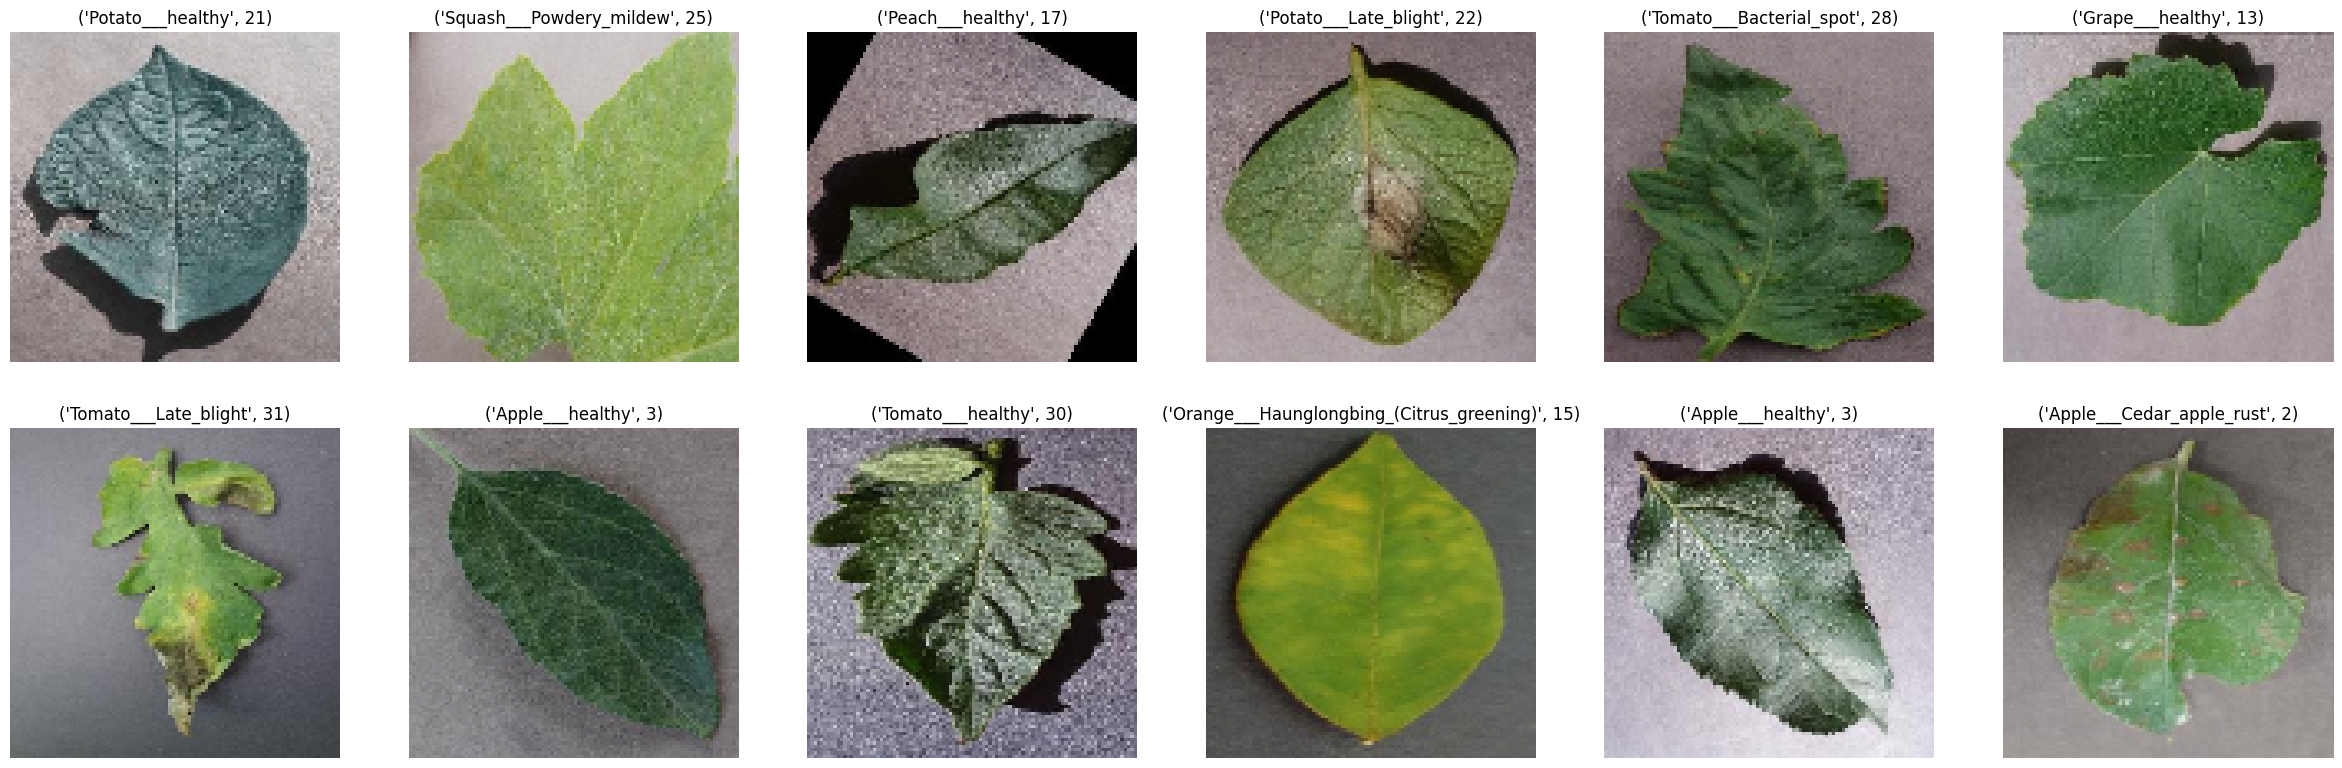

In [81]:
plt.figure(figsize=(30, 30))
for n, i in enumerate(list(np.random.randint(0, len(train_images), 12))):
    plt.subplot(6, 6, n+1)
    plt.imshow(train_images[i])
    plt.axis('off')
    plt.title(getlabel(train_labels[i]))


We have now plotted some of the images, with their labels and indexs.

In [82]:
validation_images = []
validation_labels = []

for folder in os.listdir(validation_path):
    files = gb.glob(pathname=str(validation_path + "/" + folder + "/*.JPG")) + \
        gb.glob(pathname=str(validation_path + "/" + folder + "/*.jpg"))
    for file in files:
        img = cv2.imread(file)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        validation_images.append(list(img))
        validation_labels.append(dataset_labels[folder])


In [83]:
validation_images, validation_labels = np.array(validation_images), np.array(validation_labels)
validation_images.shape, validation_labels.shape

((35144, 100, 100, 3), (35144,))

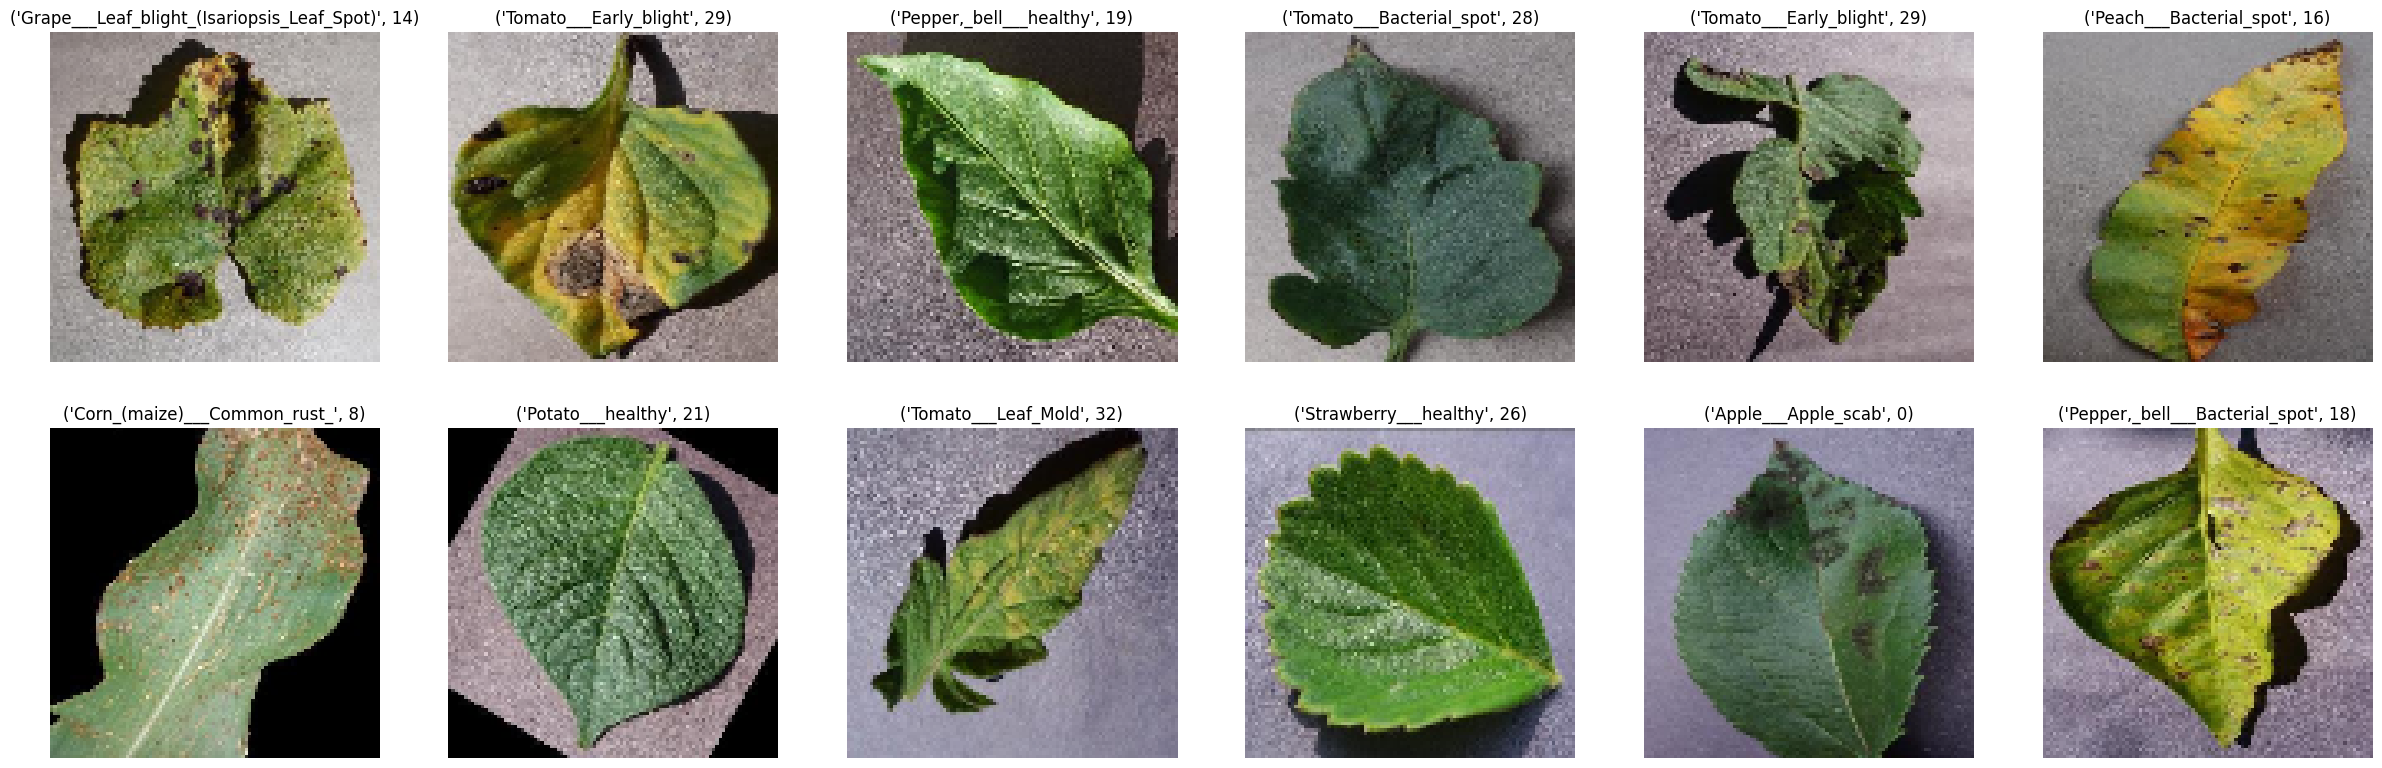

In [84]:
plt.figure(figsize=(30, 30))
for n, i in enumerate(list(np.random.randint(0, len(validation_images), 12))):
    plt.subplot(6, 6, n+1)
    plt.imshow(validation_images[i])
    plt.axis('off')
    plt.title(getlabel(validation_labels[i]))


In [85]:
test_images = []

for folder in (os.listdir(test_path)):
    files = gb.glob(pathname=str(test_path + "/" + folder + "/*.JPG")) + \
        gb.glob(pathname=str(test_path + "/" + folder + "/*.jpg"))
    for file in files:
        img = cv2.imread(file)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_images.append(list(img))


In [86]:
np.array(test_images).shape

(66, 100, 100, 3)

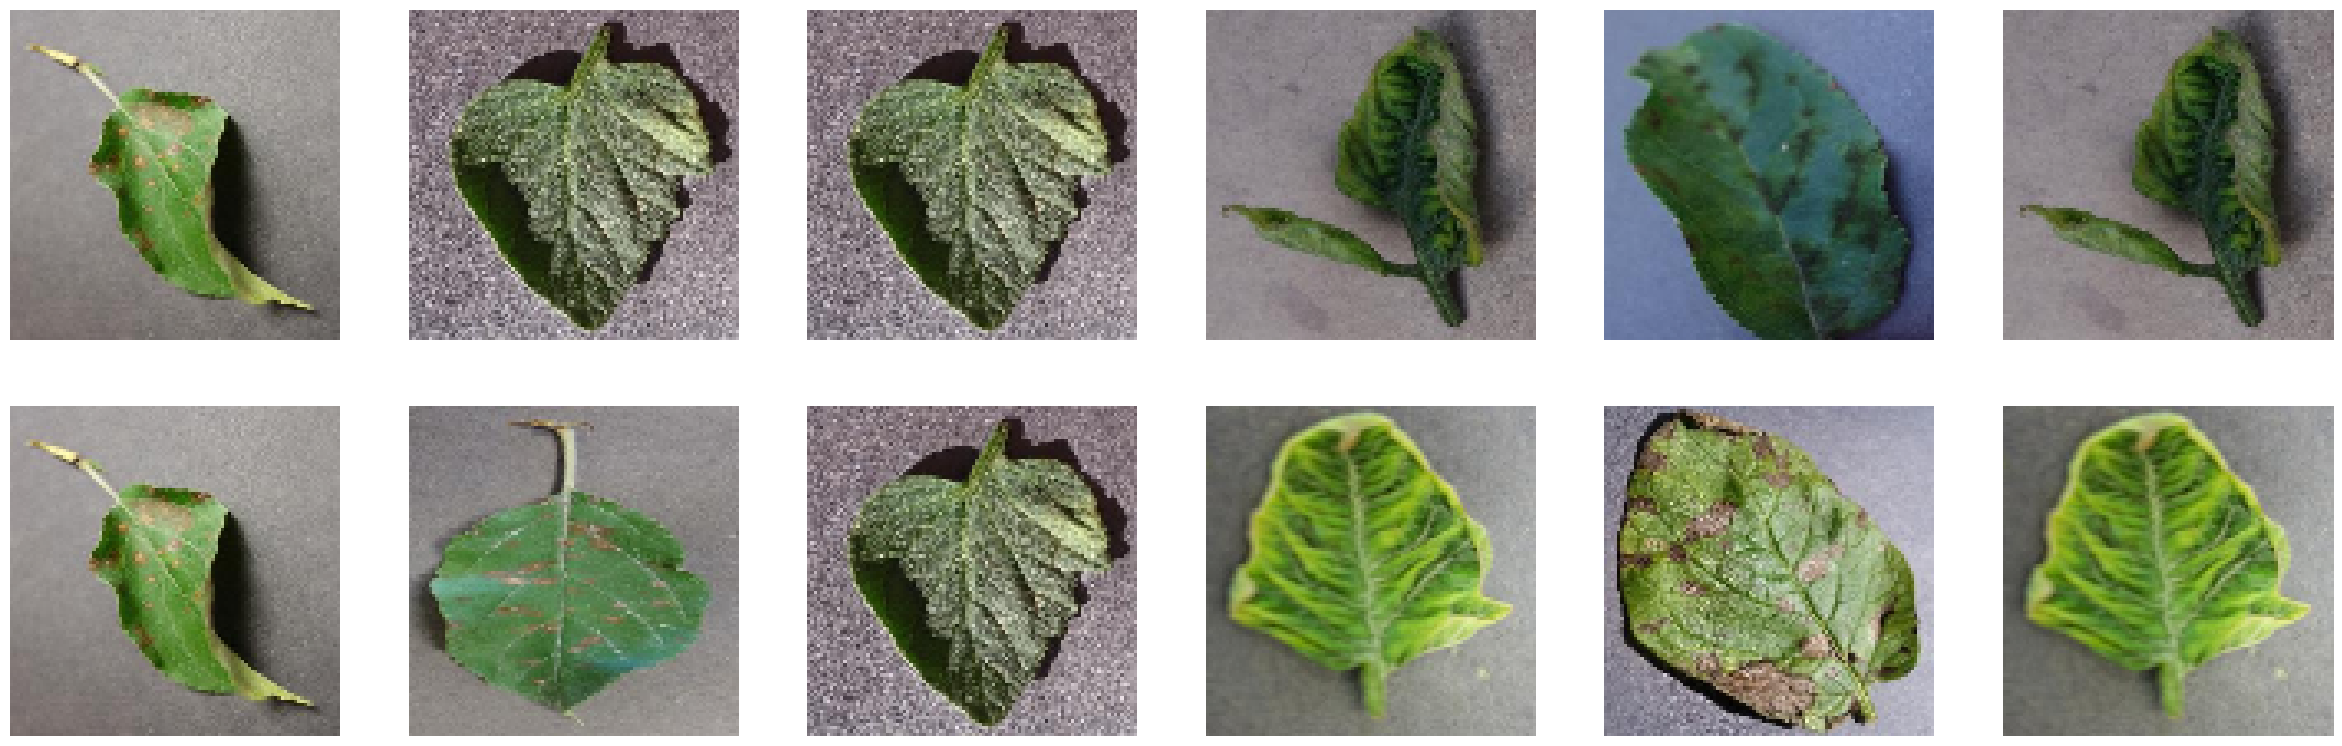

In [87]:
plt.figure(figsize=(30, 30))
for n, i in enumerate(list(np.random.randint(0, len(test_images), 12))):
    plt.subplot(6, 6, n+1)
    plt.imshow(test_images[i])
    plt.axis('off')


In [91]:
#initializing train, test and prediction datasets
x_train = train_images
y_train = train_labels
x_test = validation_images
y_test = validation_labels
x_preds = test_images


It's obvious that category of disease, which is of type 'str', cannot be passed directly to our model(as all ML models utilize mathematics). Hence, we will implement 'One-Hot Encoding', which will encode the 'str' type to mappable integers, which can be passed to our neural network.

In [93]:
#preparing for encoding

x_train = x_train.astype('float32')
x_train = x_train / 255

x_test = x_test.astype('float32')
x_test = x_test / 255

x_preds = x_preds.astype('float32')
x_preds = x_preds / 255

KeyboardInterrupt: 

In [ ]:
#Encoding

print(" Shape before one-hot encoding : ", y_train.shape)
y_train_encoded = tf.keras.utils.to_categorical(y_train, len(categs))
y_test_encoded = tf.keras.utils.to_categorical(y_test, len(categs))
print(" Shape after one-hot encoding : ", y_train.shape)
